In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

# Fetch data

In [4]:
initial_data_url = "https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6"
final_data_url = "https://data.mendeley.com/datasets/kg72dst75p/1"

In [5]:
data_1a = pd.read_csv("../data/Coronavirus_Data_Cases_1a. Per day.csv", sep=";", encoding="latin-1", index_col=0)
data_1b = pd.read_csv("../data/Coronavirus_Data_Cases_1b. Per date.csv", sep=";", encoding="latin-1", index_col=0)
data_2a = pd.read_csv("../data/Coronavirus_Data_Cases_2a. Per day_population.csv", sep=";", encoding="latin-1", index_col=0)
data_2b = pd.read_csv("../data/Coronavirus_Data_Cases_2b. Per date_population.csv", sep=";", encoding="latin-1", index_col=0)
data_5a = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per date_popul_surf.csv", sep=";", encoding="latin-1", index_col=0)
data_5b = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per day_popul_surf.csv", sep=";", encoding="latin-1", index_col=0)

In [6]:
data_1a.head()

,US,"Korea, South",China,Taiwan*,Thailand,Japan,Vietnam,Singapore,France,Nepal,...,Anguilla-United Kingdom,British Virgin Islands-United Kingdom,Turks and Caicos Islands-United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone,"Bonaire, Sint Eustatius and Saba-Netherlands",Malawi,Falkland Islands (Islas Malvinas)-United Kingdom
Country/Region,,,,,,,,,,,,,,,,,,,,,
1,1,1,548,1,2,2,2.0,1.0,2.0,1.0,...,2.0,2.0,4.0,2.0,3.0,2.0,1.0,2.0,3.0,1.0
2,1,1,643,1,3,2,2.0,3.0,3.0,1.0,...,2.0,2.0,4.0,2.0,4.0,2.0,2.0,2.0,3.0,NaN
3,2,2,920,3,5,2,2.0,3.0,3.0,1.0,...,2.0,2.0,5.0,2.0,4.0,3.0,2.0,2.0,4.0,NaN
4,2,2,1406,3,7,2,2.0,4.0,3.0,1.0,...,2.0,3.0,5.0,2.0,4.0,3.0,2.0,NaN,NaN,NaN
5,5,3,2075,4,8,4,2.0,5.0,4.0,1.0,...,2.0,3.0,6.0,9.0,4.0,3.0,4.0,NaN,NaN,NaN


In [7]:
data_2b.head()

,San Marino,Andorra,Luxembourg,Iceland,Faroe Islands-Denmark,Gibraltar-United Kingdom,Spain,Switzerland,Italy,Liechtenstein,...,Bangladesh,Tanzania,Ethiopia,Mozambique,Nepal,Angola,Burundi,Sudan,Malawi,Papua New Guinea
Population,33931.0,77265.0,625978.0,341243.0,48863.0,33691.0,46754778.0,8654622.0,60461826.0,38128.0,...,164689383.0,59734218.0,114963588.0,31255435.0,2.913681e+07,32866272.0,11890784.0,43849260.0,19129952.0,8947024.0
22/01/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
23/01/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
24/01/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
25/01/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.432085e-02,0.0,0.0,0.0,0.0,0.0


# Cleaning Data
## Adjust Data Types

In [10]:
data_1b = data_1b.select_dtypes(exclude=["object"]) #Columns need to be adjusted, not excluded
assert np.all(data_1b.dtypes == np.float64)
#problem is the last ratio row, when the datatype is not a numeric change the values into pd.NaN

# Visualizations (Cases per Day)

[ ] Select only 30 countries, respectively

In [9]:
first_day_1a = data_1a.columns #Needs to be adapted to display the order of the countries according to their first occurence of cases 
data_1a_trunc = data_1a#[data_1a.columns[first_day_1a]].loc[:30] #Needs to be adapted to display the first 30 countries with cases


data_1b_trunc = data_1b#[]

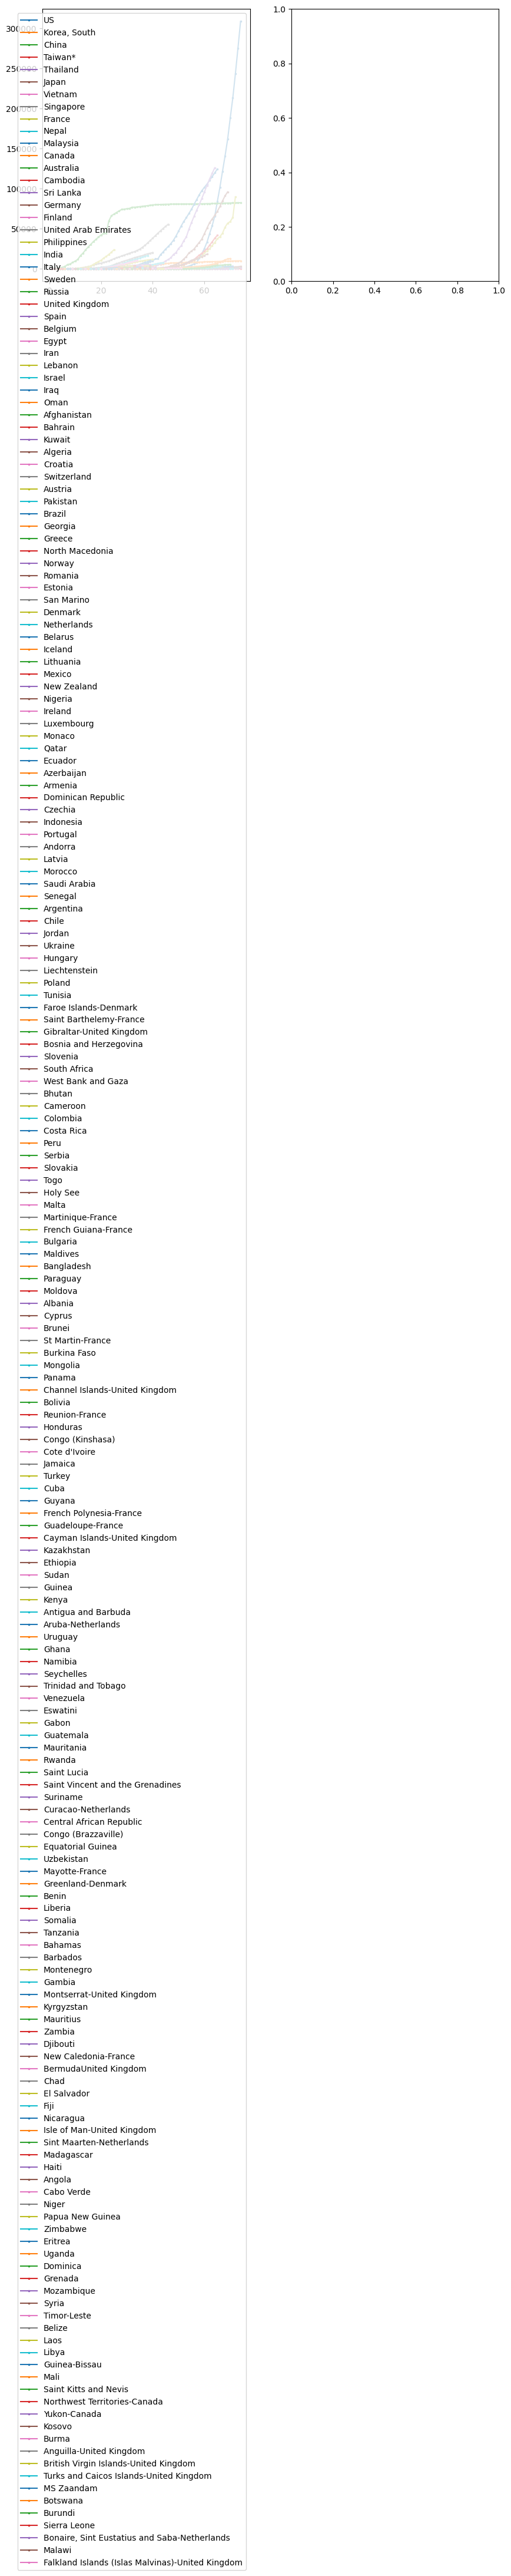

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=2)

axes[0].plot(data_1a_trunc
            , marker="s"
            , markersize=2
            , label=data_1a_trunc.columns)
axes[0].legend()

# axes[1].plot(data_1b_trunc
#             , marker="s"
#             , markersize=2
#             , label=data_1b_trunc.columns)
# axes[1].legend()

plt.show()
fig.savefig("../figures/Fig1.png")

# Agglomerative Clustering